# ECG Contrastive Learning Model Evaluation

This notebook provides a comprehensive evaluation pipeline for the trained ECG contrastive encoder:

1. **Clustering Analysis**: t-SNE/UMAP visualization and clustering quality metrics
2. **Attention Map Analysis**: Visualizing self-attention and cross-attention patterns  
3. **Downstream Classification**: Linear probing vs fine-tuning comparison

This notebook was for the most part done by *Claude.*

## 1. Setup and Model Loading

In [1]:
import sys
from pathlib import Path
from typing import Dict, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Subset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.manifold import TSNE
from sklearn.metrics import (
    accuracy_score,
    f1_score,
    confusion_matrix,
    classification_report,
    silhouette_score,
    davies_bouldin_score,
    calinski_harabasz_score,
)
from tqdm.notebook import tqdm

from src.dual_view_transformer import ECGEncoder, ECGModelConfig
from src.checkpoint_manager import CheckpointManager
from src.datasets import ECGDataset

LABEL_NAMES = {0: "NORM", 1: "MI", 2: "STTC", 3: "HYP", 4: "CD"}
NUM_CLASSES = 5

plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette("husl")

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")

Creating simple baseline model...

Simple Model Summary:

Compare to complex model: 31.21M parameters
Using device: cuda
GPU: NVIDIA GB10


/home/aimakeradmin/shady/Self-Supervied-Contrastive-Representation-Learning-ECG-Signals/.venv/lib/python3.12/site-packages/torch/cuda/__init__.py:435: UserWarning: 
    Found GPU0 NVIDIA GB10 which is of cuda capability 12.1.
    Minimum and Maximum cuda capability supported by this version of PyTorch is
    (8.0) - (12.0)
    
  queued_call()


In [ ]:
# Model configuration (must match training config from single_gpu_training.py)

# NOTE: You might need to adjust these config values based on the saved model's architecture or last training run.
config = ECGModelConfig(
        sequence_length=2500,          # Keep as-is for 5s segments
        num_channels=12,               # Standard 12-lead ECG
        encoder_embed_dim=384,         # Reduced from 520 (sweet spot for efficiency)
        d_model=512,                   # Reduced from 768
        time_token_dim=192,            # Reduced from 128 (lighter embedding)
        channel_token_dim=512,         # Reduced from 1024
        time_heads=6,                  # Reduced from 4 (must divide encoder_embed_dim)
        channel_heads=6,               # Reduced from 4
        time_layers=4,                 # Reduced from 7 (biggest memory saver)
        channel_layers=4,              # Reduced from 9
        ff_multiplier=5,               # Match training config (384 * 5 = 1920 hidden dim)
        dropout=0.3,                   # Reduced from 0.5 (0.5 is quite aggressive)
        projection_dim=256,            # Reduced from 512 (sufficient for contrastive)
        time_conv_kernel_size=3,       # Slightly larger than 1 for temporal context
        channel_conv_kernel_size=5,    # Keep as-is
        channel_conv_stride=2,         # Keep as-is
        channel_token_dropout=0.3,
        dtype=torch.bfloat16,          # Keep for memory efficiency
        fusion_hidden_dim=2048,        # Match training config to align checkpoint
        fusion_dropout=0.3,            # Reduced from 0.5
        use_flash_attention=True,      # Keep enabled
    ) 

model = ECGEncoder(config).to(device)

# Load trained checkpoint
MODEL_PATH = Path("/home/aimakeradmin/shady/Self-Supervied-Contrastive-Representation-Learning-ECG-Signals/checkpoint_epoch_376.pt")
checkpoint_manager = CheckpointManager(checkpoint_dir="../models/checkpoints")
checkpoint = checkpoint_manager.load_checkpoint(
    MODEL_PATH,
    model,
    map_location=device,
)

print(f"Loaded checkpoint from epoch {checkpoint['epoch']}")
print(f"Validation loss: {checkpoint['loss']:.4f}")
print(f"Total parameters: {sum(p.numel() for p in model.parameters()):,}")

Loaded checkpoint from epoch 376 with metric 1.7574
Loaded checkpoint from epoch 376
Validation loss: 1.7574
Total parameters: 21,477,233


In [3]:
from torch.utils.data import ConcatDataset

# Load datasets
data_dir = Path("../data/processed")

train_dataset = ECGDataset(
    segment_a_path=data_dir / "train_segment_a.npy",
    segment_b_path=data_dir / "train_segment_b.npy",
    labels_path=data_dir / "train_labels.npy",
)

val_dataset = ECGDataset(
    segment_a_path=data_dir / "val_segment_a.npy",
    segment_b_path=data_dir / "val_segment_b.npy",
    labels_path=data_dir / "val_labels.npy",
)

test_dataset = ECGDataset(
    segment_a_path=data_dir / "test_segment_a.npy",
    segment_b_path=data_dir / "test_segment_b.npy",
    labels_path=data_dir / "test_labels.npy",
)

# Combine val and test datasets
full_test_dataset = ConcatDataset([val_dataset, test_dataset])

print(f"Train samples: {len(train_dataset)}")
print(f"Val samples: {len(val_dataset)}")
print(f"Test samples: {len(test_dataset)}")
print(f"Number of classes: {train_dataset.num_classes}")

Train samples: 12978
Val samples: 1642
Test samples: 1652
Number of classes: 5


## 2. Clustering Analysis

Evaluate the quality of learned representations by analyzing clustering tendency in the embedding space.

In [4]:
def extract_embeddings(
    model: nn.Module,
    dataloader: DataLoader,
    device: torch.device,
) -> Tuple[np.ndarray, np.ndarray]:
    """Extract embeddings and labels from the model."""
    model.eval()
    all_embeddings = []
    all_labels = []

    with torch.no_grad():
        for signals, labels in tqdm(dataloader, desc="Extracting embeddings"):
            signals = signals.to(device)
            representations, _ = model(signals)
            all_embeddings.append(representations.to(torch.float32).cpu().numpy())
            all_labels.extend(labels.cpu().numpy() if torch.is_tensor(labels) else labels)

    embeddings = np.concatenate(all_embeddings, axis=0)
    labels_array = np.array(all_labels, dtype=int)
    return embeddings, labels_array


def compute_clustering_metrics(embeddings: np.ndarray, labels: np.ndarray) -> Dict[str, float]:
    """Compute clustering quality metrics."""
    return {
        "silhouette_score": silhouette_score(embeddings, labels),
        "davies_bouldin_score": davies_bouldin_score(embeddings, labels),
        "calinski_harabasz_score": calinski_harabasz_score(embeddings, labels),
    }

In [5]:
# Extract embeddings from test set
batch_size = 86
test_loader = DataLoader(full_test_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

test_embeddings, test_labels = extract_embeddings(model, test_loader, device)
print(f"Extracted embeddings shape: {test_embeddings.shape}")
print(f"Labels shape: {test_labels.shape}")
print(f"Label distribution: {np.bincount(test_labels)}")

Extracting embeddings:   0%|          | 0/39 [00:00<?, ?it/s]

Extracted embeddings shape: (3294, 512)
Labels shape: (3294,)
Label distribution: [1829  490  499  120  356]


In [6]:
# Compute clustering metrics
clustering_metrics = compute_clustering_metrics(test_embeddings, test_labels)

print("Clustering Quality Metrics:")
print("-" * 40)
print(f"Silhouette Score:        {clustering_metrics['silhouette_score']:.4f}")
print(f"  (Range: -1 to 1, higher is better)")
print(f"Davies-Bouldin Score:    {clustering_metrics['davies_bouldin_score']:.4f}")
print(f"  (Lower is better, 0 is perfect)")
print(f"Calinski-Harabasz Score: {clustering_metrics['calinski_harabasz_score']:.4f}")
print(f"  (Higher is better)")

Clustering Quality Metrics:
----------------------------------------
Silhouette Score:        0.0076
  (Range: -1 to 1, higher is better)
Davies-Bouldin Score:    5.6452
  (Lower is better, 0 is perfect)
Calinski-Harabasz Score: 64.6519
  (Higher is better)


Computing t-SNE projection...


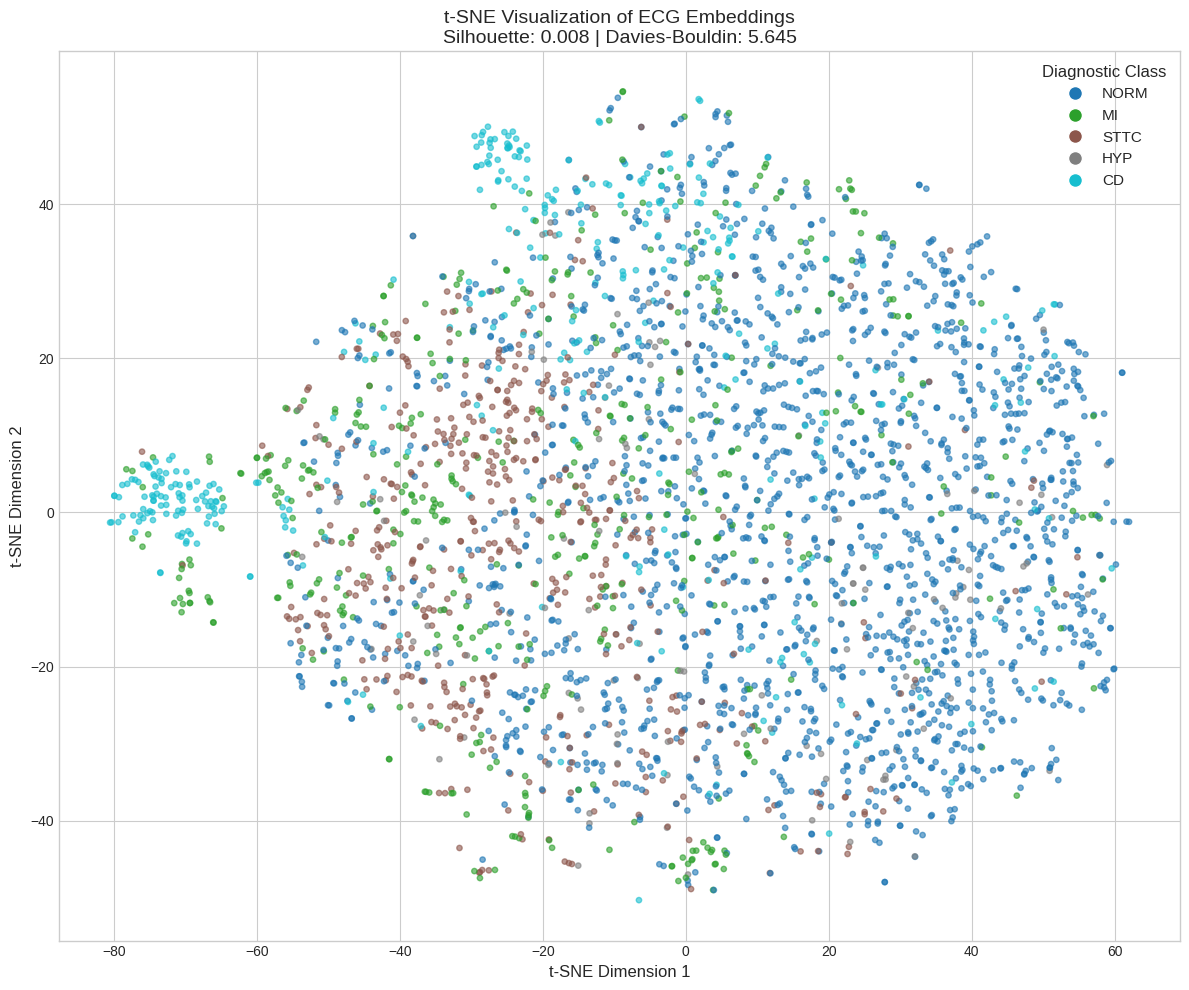

In [7]:
# t-SNE visualization
print("Computing t-SNE projection...")
tsne = TSNE(n_components=2, random_state=42, perplexity=30, max_iter=1000)
embeddings_2d_tsne = tsne.fit_transform(test_embeddings)

fig, ax = plt.subplots(figsize=(12, 10))
scatter = ax.scatter(
    embeddings_2d_tsne[:, 0],
    embeddings_2d_tsne[:, 1],
    c=test_labels,
    cmap="tab10",
    alpha=0.6,
    s=15,
)

# Create legend
unique_labels = np.unique(test_labels)
handles = [
    plt.Line2D(
        [0], [0],
        marker="o",
        color="w",
        markerfacecolor=scatter.cmap(scatter.norm(label)),
        markersize=10,
        label=LABEL_NAMES.get(label, f"Class {label}"),
    )
    for label in unique_labels
]
ax.legend(handles=handles, title="Diagnostic Class", fontsize=11, title_fontsize=12)

ax.set_xlabel("t-SNE Dimension 1", fontsize=12)
ax.set_ylabel("t-SNE Dimension 2", fontsize=12)
ax.set_title(
    f"t-SNE Visualization of ECG Embeddings\n"
    f"Silhouette: {clustering_metrics['silhouette_score']:.3f} | "
    f"Davies-Bouldin: {clustering_metrics['davies_bouldin_score']:.3f}",
    fontsize=14,
)
plt.tight_layout()
plt.show()

Computing UMAP projection...


/home/aimakeradmin/shady/Self-Supervied-Contrastive-Representation-Learning-ECG-Signals/.venv/lib/python3.12/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


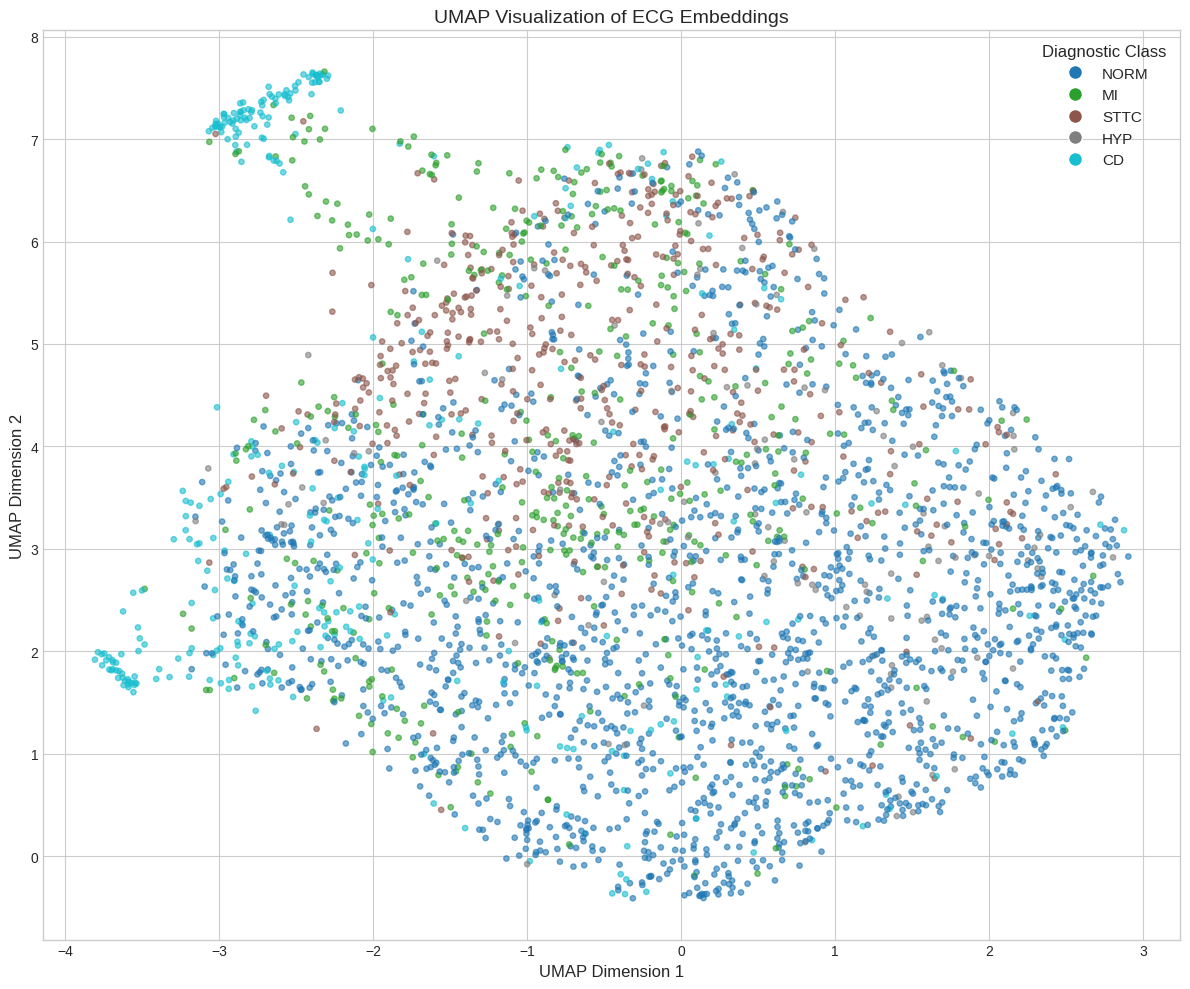

In [8]:
# UMAP visualization (requires umap-learn package)
try:
    import umap.umap_ as umap
    
    print("Computing UMAP projection...")
    reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
    embeddings_2d_umap = reducer.fit_transform(test_embeddings)
    
    fig, ax = plt.subplots(figsize=(12, 10))
    scatter = ax.scatter(
        embeddings_2d_umap[:, 0],
        embeddings_2d_umap[:, 1],
        c=test_labels,
        cmap="tab10",
        alpha=0.6,
        s=15,
    )
    
    handles = [
        plt.Line2D(
            [0], [0],
            marker="o",
            color="w",
            markerfacecolor=scatter.cmap(scatter.norm(label)),
            markersize=10,
            label=LABEL_NAMES.get(label, f"Class {label}"),
        )
        for label in unique_labels
    ]
    ax.legend(handles=handles, title="Diagnostic Class", fontsize=11, title_fontsize=12)
    
    ax.set_xlabel("UMAP Dimension 1", fontsize=12)
    ax.set_ylabel("UMAP Dimension 2", fontsize=12)
    ax.set_title("UMAP Visualization of ECG Embeddings", fontsize=14)
    plt.tight_layout()
    plt.show()
    
except ImportError:
    print("UMAP not installed. Install with: pip install umap-learn")

## 3. Attention Map Analysis

Visualize attention patterns to understand what the model focuses on. We disable Flash Attention to capture attention weights.

In [4]:
# Disable Flash Attention to capture attention weights
model.set_flash_attention(False)
model.eval()

# Get a random sample for attention visualization
sample_idx = 62
sample_signal, sample_label = train_dataset[sample_idx]
sample_signal = sample_signal.unsqueeze(0).to(device)

print(f"Analyzing sample {sample_idx} with label: {LABEL_NAMES[sample_label]}")
print(f"Signal shape: {sample_signal.shape}")

# Forward pass to capture attention
with torch.no_grad():
    representation, projection, _, _ = model(sample_signal)
    attention_maps = model.get_attention_maps(head_average=True)

print("\nCaptured attention maps:")
for name, tensor in attention_maps.items():
    if tensor is not None:
        print(f"  {name}: {tensor.shape}")
    else:
        print(f"  {name}: None")

Analyzing sample 62 with label: NORM
Signal shape: torch.Size([1, 2500, 12])

Captured attention maps:
  time_self: torch.Size([1, 2500, 2500])
  channel_self: torch.Size([1, 12, 12])
  time_to_channel: torch.Size([1, 2500, 12])
  channel_to_time: torch.Size([1, 12, 2500])


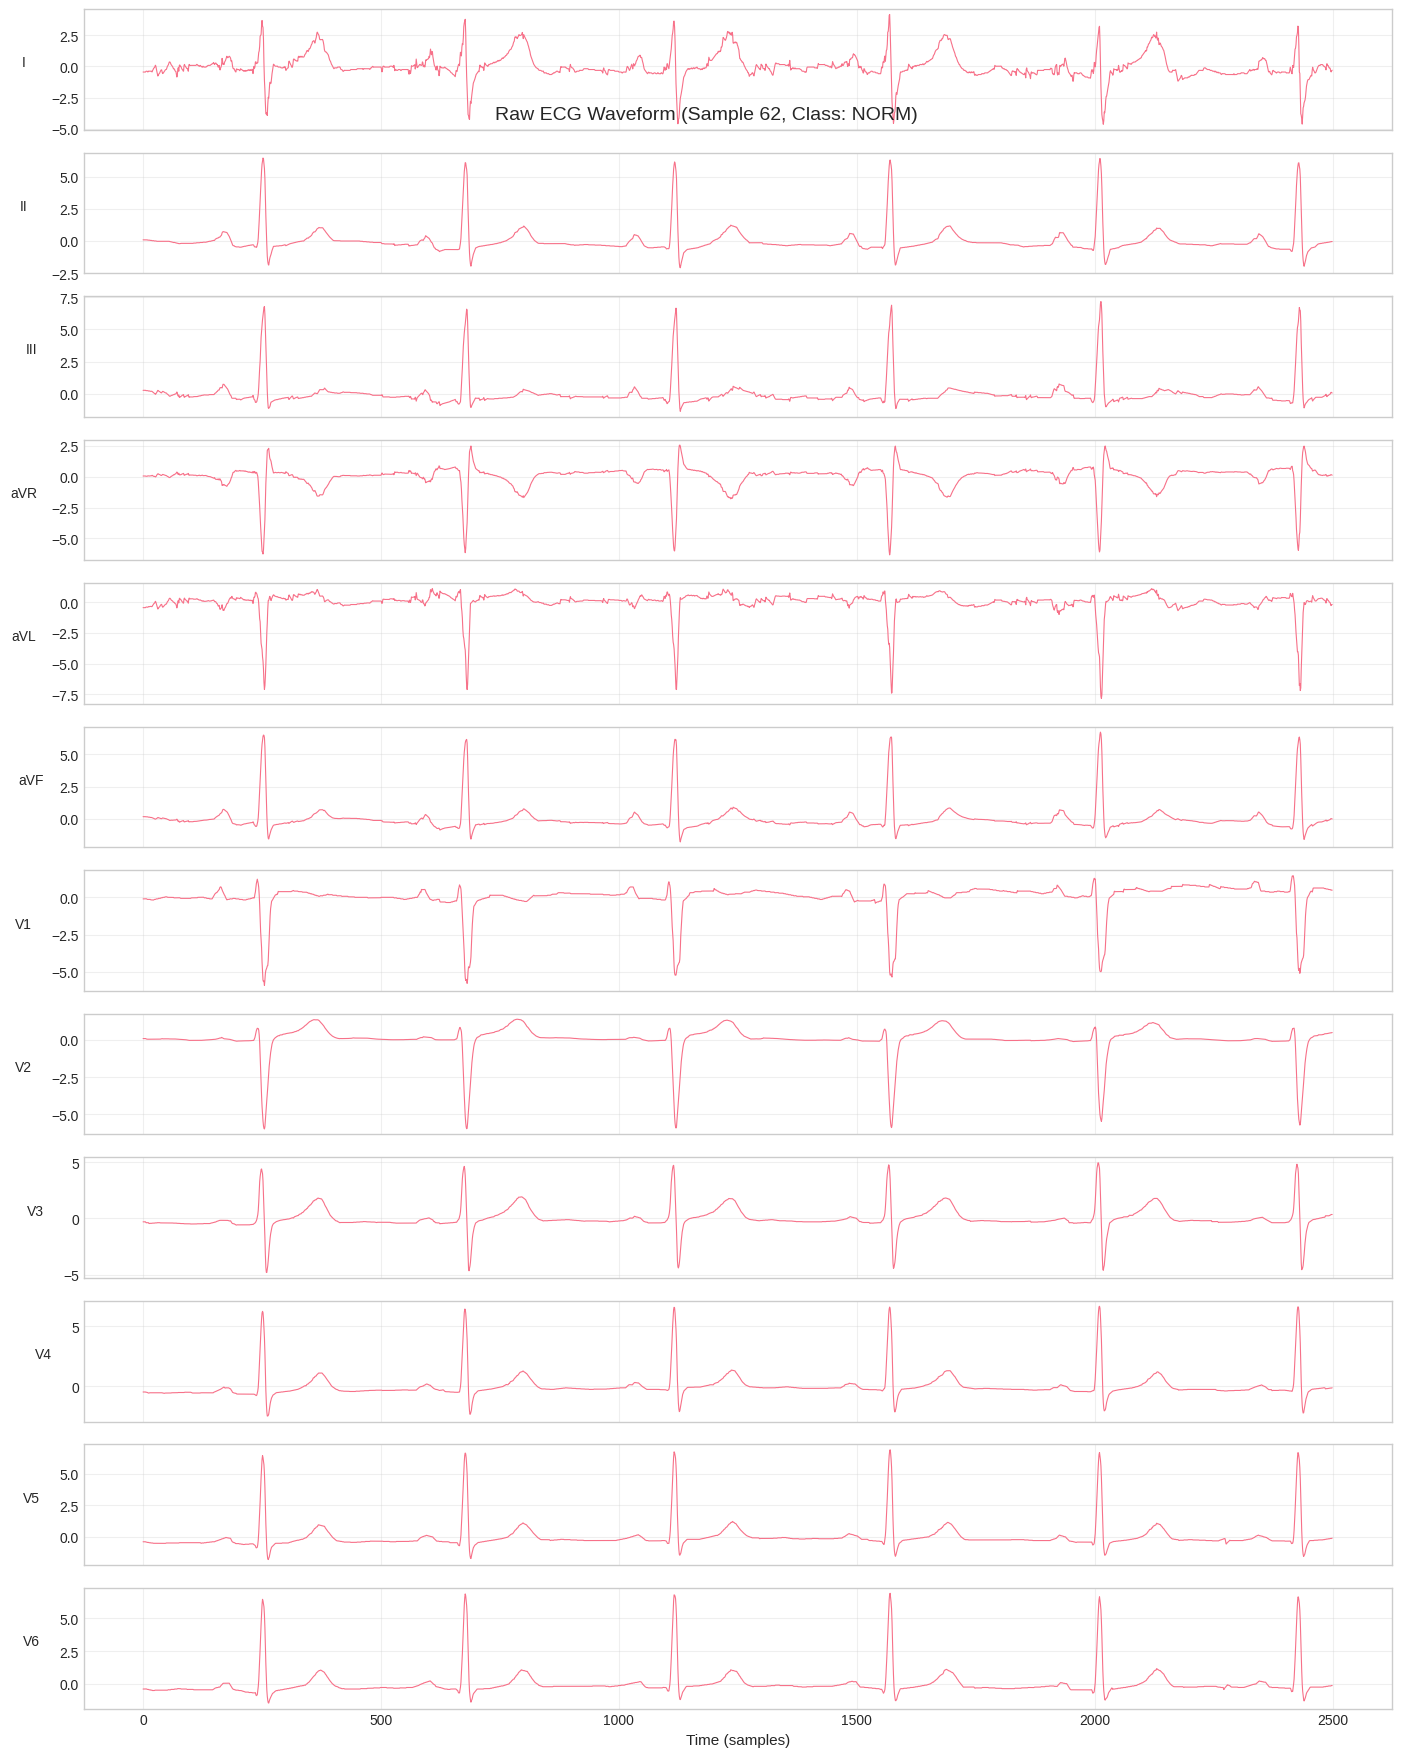

In [6]:
# Plot the full 12-lead waveform for the selected sample
lead_names = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]
signal_np = sample_signal.squeeze(0).detach().cpu().numpy()  # (12, sequence_length)
time_axis = np.arange(signal_np.shape[0])

fig, axes = plt.subplots(len(lead_names), 1, figsize=(14, 18), sharex=True)
for i, (ax, lead) in enumerate(zip(axes, lead_names)):
    ax.plot(time_axis, signal_np[:, i], linewidth=0.8)
    ax.set_ylabel(lead, rotation=0, labelpad=20, fontsize=10)
    ax.grid(alpha=0.3)

axes[-1].set_xlabel("Time (samples)", fontsize=11)
fig.suptitle(f"Raw ECG Waveform (Sample {sample_idx}, Class: {LABEL_NAMES[sample_label]})", fontsize=14, y=0.92)
plt.tight_layout()
plt.show()

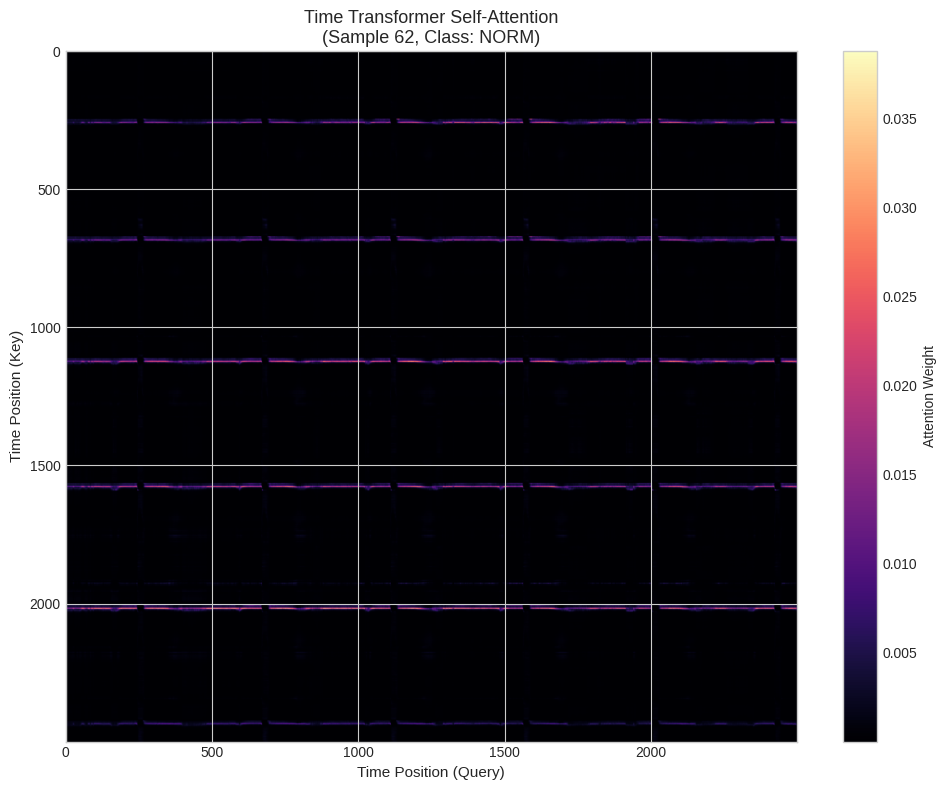

In [8]:
def plot_attention_heatmap(
    attention: torch.Tensor,
    title: str,
    xlabel: str = "Query Position",
    ylabel: str = "Key Position",
    figsize: Tuple[int, int] = (10, 8),
    sample_every: int = 1,
) -> plt.Figure:
    """Plot attention weights as a heatmap with queries as columns and keys as rows."""
    attn_np = attention.float().cpu().numpy().T  # Transpose to put queries in columns
    
    # Subsample for large attention maps
    if attn_np.shape[0] > 100:
        attn_np = attn_np
    
    fig, ax = plt.subplots(figsize=figsize)
    im = ax.imshow(attn_np, cmap="magma", aspect="auto")
    ax.set_xlabel(xlabel, fontsize=11)
    ax.set_ylabel(ylabel, fontsize=11)
    ax.set_title(title, fontsize=13)
    plt.colorbar(im, ax=ax, label="Attention Weight")
    plt.tight_layout()
    return fig


# Visualize Time Self-Attention (last layer)
if attention_maps.get("time_self") is not None:
    time_attn = attention_maps["time_self"][0]  # Remove batch dimension
    fig = plot_attention_heatmap(
        time_attn,
        title=f"Time Transformer Self-Attention\n(Sample {sample_idx}, Class: {LABEL_NAMES[sample_label]})",
        xlabel="Time Position (Query)",
        ylabel="Time Position (Key)",
        sample_every=25,  # Subsample for visualization (2500 -> 100 points)
    )
    plt.show()
else:
    print("Time self-attention not captured")

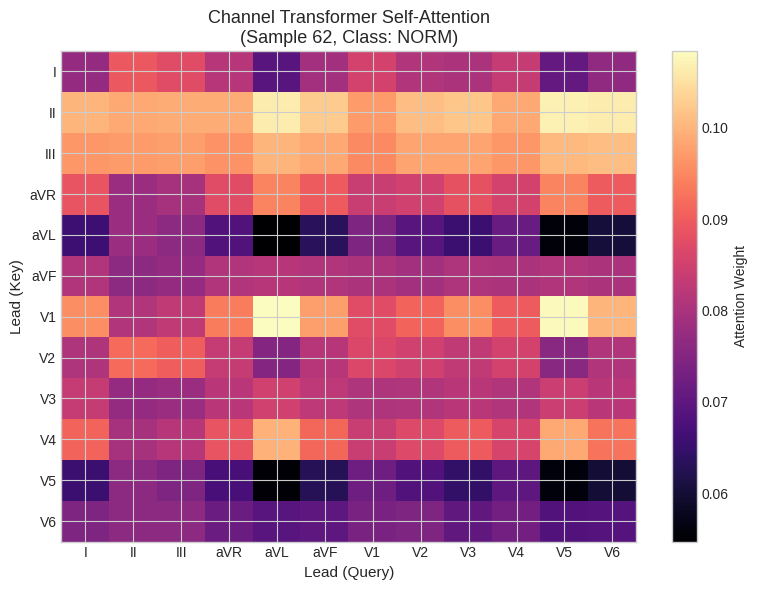

In [9]:
# Visualize Channel Self-Attention (last layer)
if attention_maps.get("channel_self") is not None:
    channel_attn = attention_maps["channel_self"][0]  # Remove batch dimension
    
    fig, ax = plt.subplots(figsize=(8, 6))
    im = ax.imshow(channel_attn.float().cpu().numpy().T, cmap="magma", aspect="auto")
    
    # Label ECG leads
    lead_names = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]
    ax.set_xticks(range(12))
    ax.set_yticks(range(12))
    ax.set_xticklabels(lead_names, fontsize=10)
    ax.set_yticklabels(lead_names, fontsize=10)
    
    ax.set_xlabel("Lead (Query)", fontsize=11)
    ax.set_ylabel("Lead (Key)", fontsize=11)
    ax.set_title(
        f"Channel Transformer Self-Attention\n(Sample {sample_idx}, Class: {LABEL_NAMES[sample_label]})",
        fontsize=13,
    )
    plt.colorbar(im, ax=ax, label="Attention Weight")
    plt.tight_layout()
    plt.show()
else:
    print("Channel self-attention not captured")

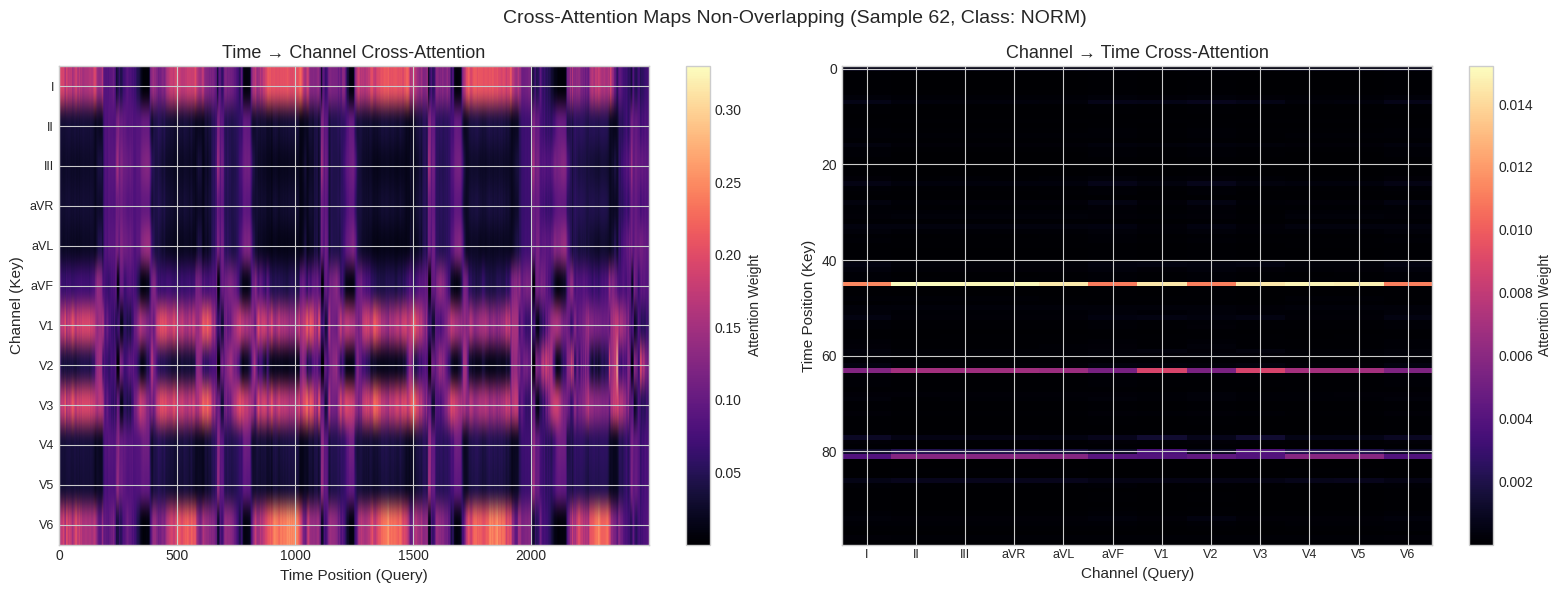

In [12]:
# Visualize Cross-Attention maps
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# Time-to-Channel cross-attention (time queries attending to channel keys)
if attention_maps.get("time_to_channel") is not None:
    t2c_attn = attention_maps["time_to_channel"][0].float().cpu().numpy().T
    # Subsample time dimension (now in columns after transpose)
    t2c_attn_sampled = t2c_attn # (12, 100)
    
    im0 = axes[0].imshow(t2c_attn_sampled, cmap="magma", aspect="auto")
    axes[0].set_xlabel("Time Position (Query)", fontsize=11)
    axes[0].set_ylabel("Channel (Key)", fontsize=11)
    axes[0].set_title("Time → Channel Cross-Attention", fontsize=13)
    
    lead_names = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]
    axes[0].set_yticks(range(12))
    axes[0].set_yticklabels(lead_names, fontsize=9)
    plt.colorbar(im0, ax=axes[0], label="Attention Weight")

# Channel-to-Time cross-attention (channel queries attending to time keys)
if attention_maps.get("channel_to_time") is not None:
    c2t_attn = attention_maps["channel_to_time"][0].float().cpu().numpy().T
    # Subsample time dimension (now in rows after transpose)
    c2t_attn_sampled = c2t_attn[::25, :]  # (100, 12)
    
    im1 = axes[1].imshow(c2t_attn_sampled, cmap="magma", aspect="auto")
    axes[1].set_xlabel("Channel (Query)", fontsize=11)
    axes[1].set_ylabel("Time Position (Key)", fontsize=11)
    axes[1].set_title("Channel → Time Cross-Attention", fontsize=13)
    
    lead_names = ["I", "II", "III", "aVR", "aVL", "aVF", "V1", "V2", "V3", "V4", "V5", "V6"]
    axes[1].set_xticks(range(12))
    axes[1].set_xticklabels(lead_names, fontsize=9)
    plt.colorbar(im1, ax=axes[1], label="Attention Weight")

plt.suptitle(f"Cross-Attention Maps Non-Overlapping (Sample {sample_idx}, Class: {LABEL_NAMES[sample_label]})", fontsize=14)
plt.tight_layout()
plt.show()

# Re-enable Flash Attention for efficiency in subsequent operations
model.set_flash_attention(True)

## 4. Downstream Classification

Compare representation quality using:
1. **Linear Probing**: Train only a linear classifier on frozen embeddings
2. **Fine-tuning**: Train the full model on 25% of labeled data

In [13]:
class LinearProbe(nn.Module):
    """Simple linear classifier for probing learned representations."""
    
    def __init__(self, input_dim: int, num_classes: int):
        super().__init__()
        self.linear = nn.Linear(input_dim, num_classes)
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        return self.linear(x)


class FineTuneClassifier(nn.Module):
    """ECG encoder with classification head for fine-tuning."""
    
    def __init__(self, encoder: ECGEncoder, num_classes: int, freeze_encoder: bool = False):
        super().__init__()
        self.encoder = encoder
        self.classifier = nn.Linear(encoder.fusion.linear_out.out_features, num_classes)
        
        if freeze_encoder:
            for param in self.encoder.parameters():
                param.requires_grad = False
    
    def forward(self, x: torch.Tensor) -> torch.Tensor:
        representation, _ = self.encoder(x)
        return self.classifier(representation.float())
    
    def unfreeze_encoder(self):
        for param in self.encoder.parameters():
            param.requires_grad = True

In [14]:
def train_classifier(
    classifier: nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
    epochs: int,
    lr: float,
    device: torch.device,
    use_embeddings: bool = True,
) -> Dict[str, list]:
    """Train a classifier and return training history."""
    optimizer = torch.optim.Adam(
        filter(lambda p: p.requires_grad, classifier.parameters()),
        lr=lr,
    )
    criterion = nn.CrossEntropyLoss()
    scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode="min", patience=5, factor=0.5)
    
    history = {"train_loss": [], "val_loss": [], "val_acc": [], "val_f1": []}
    
    for epoch in range(epochs):
        # Training
        classifier.train()
        train_loss = 0.0
        for batch in train_loader:
            if use_embeddings:
                embeddings, labels = batch
                embeddings, labels = embeddings.to(device), labels.to(device)
                logits = classifier(embeddings)
            else:
                signals, labels = batch
                signals, labels = signals.to(device), labels.to(device)
                logits = classifier(signals)
            
            loss = criterion(logits, labels)
            optimizer.zero_grad()
            loss.backward()
            torch.nn.utils.clip_grad_norm_(classifier.parameters(), max_norm=1.0)
            optimizer.step()
            train_loss += loss.item()
        
        train_loss /= len(train_loader)
        history["train_loss"].append(train_loss)
        
        # Validation
        classifier.eval()
        val_loss = 0.0
        all_preds = []
        all_labels = []
        
        with torch.no_grad():
            for batch in val_loader:
                if use_embeddings:
                    embeddings, labels = batch
                    embeddings, labels = embeddings.to(device), labels.to(device)
                    logits = classifier(embeddings)
                else:
                    signals, labels = batch
                    signals, labels = signals.to(device), labels.to(device)
                    logits = classifier(signals)
                
                loss = criterion(logits, labels)
                val_loss += loss.item()
                
                preds = logits.argmax(dim=1)
                all_preds.extend(preds.cpu().numpy())
                all_labels.extend(labels.cpu().numpy())
        
        val_loss /= len(val_loader)
        val_acc = accuracy_score(all_labels, all_preds)
        val_f1 = f1_score(all_labels, all_preds, average="macro")
        
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)
        history["val_f1"].append(val_f1)
        
        scheduler.step(val_loss)
        
        if (epoch + 1) % 5 == 0 or epoch == 0:
            print(f"Epoch {epoch+1:3d}/{epochs}: Train Loss={train_loss:.4f}, Val Loss={val_loss:.4f}, Val Acc={val_acc:.4f}, Val F1={val_f1:.4f}")
    
    return history


def evaluate_classifier(
    classifier: nn.Module,
    test_loader: DataLoader,
    device: torch.device,
    use_embeddings: bool = True,
) -> Dict[str, float]:
    """Evaluate classifier on test set."""
    classifier.eval()
    all_preds = []
    all_labels = []
    
    with torch.no_grad():
        for batch in test_loader:
            if use_embeddings:
                embeddings, labels = batch
                embeddings, labels = embeddings.to(device), labels.to(device)
                logits = classifier(embeddings)
            else:
                signals, labels = batch
                signals, labels = signals.to(device), labels.to(device)
                logits = classifier(signals)
            
            preds = logits.argmax(dim=1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    
    return {
        "accuracy": accuracy_score(all_labels, all_preds),
        "f1_macro": f1_score(all_labels, all_preds, average="macro"),
        "f1_weighted": f1_score(all_labels, all_preds, average="weighted"),
        "predictions": np.array(all_preds),
        "labels": np.array(all_labels),
    }

### 4.1 Linear Probing

Train a linear classifier on frozen embeddings extracted from the encoder.

In [15]:
# Extract embeddings for all splits
print("Extracting embeddings for linear probing...")

train_loader_full = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=0)
val_loader_full = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=0)

train_embeddings, train_labels = extract_embeddings(model, train_loader_full, device)
val_embeddings, val_labels = extract_embeddings(model, val_loader_full, device)

print(f"Train embeddings: {train_embeddings.shape}")
print(f"Val embeddings: {val_embeddings.shape}")
print(f"Test embeddings: {test_embeddings.shape}")

Extracting embeddings for linear probing...


Extracting embeddings:   0%|          | 0/151 [00:00<?, ?it/s]

Extracting embeddings:   0%|          | 0/20 [00:00<?, ?it/s]

Train embeddings: (12978, 512)
Val embeddings: (1642, 512)
Test embeddings: (3294, 512)


In [16]:
# Create embedding datasets for linear probing
class EmbeddingDataset(torch.utils.data.Dataset):
    def __init__(self, embeddings: np.ndarray, labels: np.ndarray):
        self.embeddings = torch.from_numpy(embeddings).float()
        self.labels = torch.from_numpy(labels).long()
    
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return self.embeddings[idx], self.labels[idx]

train_emb_dataset = EmbeddingDataset(train_embeddings, train_labels)
val_emb_dataset = EmbeddingDataset(val_embeddings, val_labels)
test_emb_dataset = EmbeddingDataset(test_embeddings, test_labels)

train_emb_loader = DataLoader(train_emb_dataset, batch_size=256, shuffle=True)
val_emb_loader = DataLoader(val_emb_dataset, batch_size=256, shuffle=False)
test_emb_loader = DataLoader(test_emb_dataset, batch_size=256, shuffle=False)

In [20]:
# Train linear probe
embedding_dim = train_embeddings.shape[1]
linear_probe = LinearProbe(embedding_dim, NUM_CLASSES).to(device)

print(f"Training Linear Probe ({embedding_dim} -> {NUM_CLASSES})")
print("-" * 50)

linear_probe_history = train_classifier(
    linear_probe,
    train_emb_loader,
    val_emb_loader,
    epochs=50,
    lr=6e-3,
    device=device,
    use_embeddings=True,
)

# Evaluate on test set
linear_probe_results = evaluate_classifier(linear_probe, test_emb_loader, device, use_embeddings=True)

print("\n" + "=" * 50)
print("Linear Probe Test Results:")
print(f"  Accuracy: {linear_probe_results['accuracy']:.4f}")
print(f"  F1 (Macro): {linear_probe_results['f1_macro']:.4f}")
print(f"  F1 (Weighted): {linear_probe_results['f1_weighted']:.4f}")

Training Linear Probe (512 -> 5)
--------------------------------------------------
Epoch   1/50: Train Loss=0.7225, Val Loss=0.7296, Val Acc=0.7533, Val F1=0.5665
Epoch   5/50: Train Loss=0.5896, Val Loss=0.7193, Val Acc=0.7527, Val F1=0.5628
Epoch  10/50: Train Loss=0.5739, Val Loss=0.6984, Val Acc=0.7619, Val F1=0.5731
Epoch  15/50: Train Loss=0.5731, Val Loss=0.7022, Val Acc=0.7637, Val F1=0.5746
Epoch  20/50: Train Loss=0.5485, Val Loss=0.6948, Val Acc=0.7637, Val F1=0.5768
Epoch  25/50: Train Loss=0.5443, Val Loss=0.6910, Val Acc=0.7631, Val F1=0.5745
Epoch  30/50: Train Loss=0.5422, Val Loss=0.7132, Val Acc=0.7625, Val F1=0.5650
Epoch  35/50: Train Loss=0.5314, Val Loss=0.7031, Val Acc=0.7667, Val F1=0.5731
Epoch  40/50: Train Loss=0.5326, Val Loss=0.6892, Val Acc=0.7692, Val F1=0.5860
Epoch  45/50: Train Loss=0.5272, Val Loss=0.6949, Val Acc=0.7655, Val F1=0.5795
Epoch  50/50: Train Loss=0.5265, Val Loss=0.6904, Val Acc=0.7643, Val F1=0.5730

Linear Probe Test Results:
  Accura

### 4.2 Fine-tuning (25% of Training Data)

Fine-tune the entire encoder on a subset of labeled data to compare with linear probing.

In [26]:
# Create a balanced subset of training data for fine-tuning
subset_ratio: float = 0.01
subset_size: int = int(len(train_dataset) * subset_ratio)
subset_size_per_class: int = subset_size // NUM_CLASSES

labels = np.array(train_dataset.labels)
subset_indices = []
for cls in range(NUM_CLASSES):
    cls_indices = np.where(labels == cls)[0]
    sampled = np.random.choice(cls_indices, size=subset_size_per_class, replace=False)
    subset_indices.append(sampled)

subset_indices = np.concatenate(subset_indices)
np.random.shuffle(subset_indices)

train_subset = Subset(train_dataset, subset_indices)
print(
    f"Fine-tuning subset: {len(train_subset)} samples "
    f"({subset_ratio*100:.0f}% of training data), {subset_size_per_class} per class"
)

train_subset_loader = DataLoader(train_subset, batch_size=32, shuffle=True, num_workers=0)
val_loader_ft = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=0)
test_loader_ft = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=0)

Fine-tuning subset: 125 samples (1% of training data), 25 per class


In [28]:
# Create a fresh model for fine-tuning (load from checkpoint again)
finetune_model = ECGEncoder(config).to(device)
checkpoint_manager.load_checkpoint(
    MODEL_PATH,
    finetune_model,
    map_location=device,
)

# Wrap with classification head
finetune_classifier = FineTuneClassifier(finetune_model, NUM_CLASSES, freeze_encoder=False).to(device)

print(f"Fine-tuning model parameters: {sum(p.numel() for p in finetune_classifier.parameters() if p.requires_grad):,}")
print("-" * 50)

# Fine-tune with lower learning rate
finetune_history = train_classifier(
    finetune_classifier,
    train_subset_loader,
    val_loader_ft,
    epochs=10,
    lr=3e-5,  # Lower LR for fine-tuning
    device=device,
    use_embeddings=False,
)

# Evaluate on test set
finetune_results = evaluate_classifier(finetune_classifier, test_loader_ft, device, use_embeddings=False)

print("\n" + "=" * 50)
print("Fine-tuning Test Results (25% data):")
print(f"  Accuracy: {finetune_results['accuracy']:.4f}")
print(f"  F1 (Macro): {finetune_results['f1_macro']:.4f}")
print(f"  F1 (Weighted): {finetune_results['f1_weighted']:.4f}")

Loaded checkpoint from epoch 293 with loss 0.5151
Fine-tuning model parameters: 21,334,070
--------------------------------------------------
Epoch   1/10: Train Loss=1.4867, Val Loss=1.4620, Val Acc=0.3752, Val F1=0.2639


KeyboardInterrupt: 

## 5. Results Summary

In [29]:
# Comparison table
print("=" * 70)
print("EVALUATION SUMMARY")
print("=" * 70)

print("\n1. CLUSTERING QUALITY METRICS (Test Set)")
print("-" * 50)
print(f"{'Metric':<30} {'Value':<15}")
print("-" * 50)
print(f"{'Silhouette Score':<30} {clustering_metrics['silhouette_score']:.4f}")
print(f"{'Davies-Bouldin Score':<30} {clustering_metrics['davies_bouldin_score']:.4f}")
print(f"{'Calinski-Harabasz Score':<30} {clustering_metrics['calinski_harabasz_score']:.4f}")

print("\n2. DOWNSTREAM CLASSIFICATION COMPARISON")
print("-" * 50)
print(f"{'Method':<25} {'Accuracy':<12} {'F1 (Macro)':<12} {'F1 (Weighted)':<12}")
print("-" * 50)
print(f"{'Linear Probe (100%)':<25} {linear_probe_results['accuracy']:.4f}       {linear_probe_results['f1_macro']:.4f}       {linear_probe_results['f1_weighted']:.4f}")
print(f"{'Fine-tuning (25%)':<25} {finetune_results['accuracy']:.4f}       {finetune_results['f1_macro']:.4f}       {finetune_results['f1_weighted']:.4f}")
print("=" * 70)

EVALUATION SUMMARY

1. CLUSTERING QUALITY METRICS (Test Set)
--------------------------------------------------
Metric                         Value          
--------------------------------------------------
Silhouette Score               0.0076
Davies-Bouldin Score           5.6452
Calinski-Harabasz Score        64.6519

2. DOWNSTREAM CLASSIFICATION COMPARISON
--------------------------------------------------
Method                    Accuracy     F1 (Macro)   F1 (Weighted)
--------------------------------------------------
Linear Probe (100%)       0.7608       0.5743       0.7408
Fine-tuning (25%)         0.6380       0.4524       0.6333


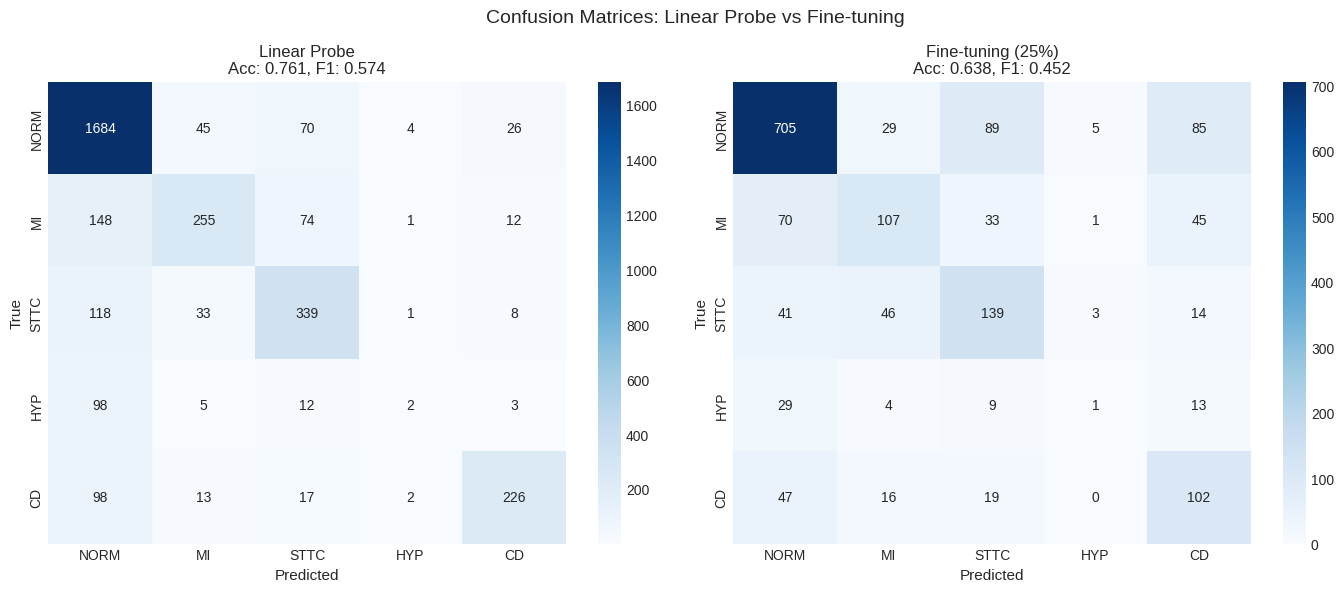

In [30]:
# Plot confusion matrices side by side
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

label_list = [LABEL_NAMES[i] for i in range(NUM_CLASSES)]

# Linear Probe confusion matrix
cm_linear = confusion_matrix(linear_probe_results['labels'], linear_probe_results['predictions'])
sns.heatmap(cm_linear, annot=True, fmt='d', cmap='Blues', ax=axes[0],
            xticklabels=label_list, yticklabels=label_list)
axes[0].set_xlabel('Predicted', fontsize=11)
axes[0].set_ylabel('True', fontsize=11)
axes[0].set_title(f'Linear Probe\nAcc: {linear_probe_results["accuracy"]:.3f}, F1: {linear_probe_results["f1_macro"]:.3f}', fontsize=12)

# Fine-tuning confusion matrix
cm_finetune = confusion_matrix(finetune_results['labels'], finetune_results['predictions'])
sns.heatmap(cm_finetune, annot=True, fmt='d', cmap='Blues', ax=axes[1],
            xticklabels=label_list, yticklabels=label_list)
axes[1].set_xlabel('Predicted', fontsize=11)
axes[1].set_ylabel('True', fontsize=11)
axes[1].set_title(f'Fine-tuning (25%)\nAcc: {finetune_results["accuracy"]:.3f}, F1: {finetune_results["f1_macro"]:.3f}', fontsize=12)

plt.suptitle('Confusion Matrices: Linear Probe vs Fine-tuning', fontsize=14)
plt.tight_layout()
plt.show()

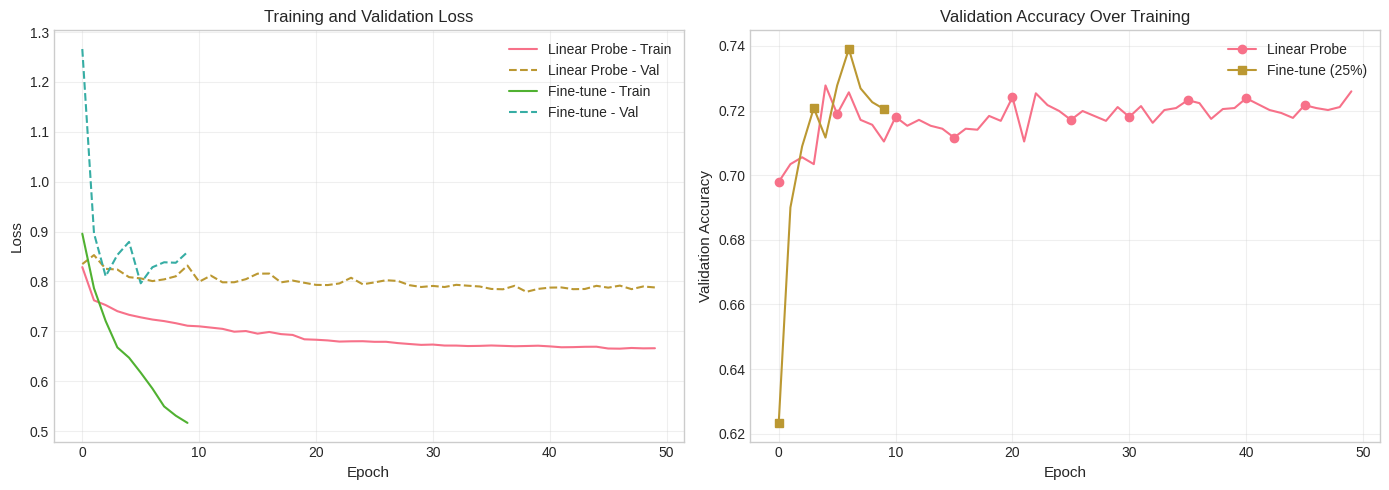

In [44]:
# Training curves comparison
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Loss curves
axes[0].plot(linear_probe_history['train_loss'], label='Linear Probe - Train', linestyle='-')
axes[0].plot(linear_probe_history['val_loss'], label='Linear Probe - Val', linestyle='--')
axes[0].plot(finetune_history['train_loss'], label='Fine-tune - Train', linestyle='-')
axes[0].plot(finetune_history['val_loss'], label='Fine-tune - Val', linestyle='--')
axes[0].set_xlabel('Epoch', fontsize=11)
axes[0].set_ylabel('Loss', fontsize=11)
axes[0].set_title('Training and Validation Loss', fontsize=12)
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Accuracy curves
axes[1].plot(linear_probe_history['val_acc'], label='Linear Probe', linestyle='-', marker='o', markevery=5)
axes[1].plot(finetune_history['val_acc'], label='Fine-tune (25%)', linestyle='-', marker='s', markevery=3)
axes[1].set_xlabel('Epoch', fontsize=11)
axes[1].set_ylabel('Validation Accuracy', fontsize=11)
axes[1].set_title('Validation Accuracy Over Training', fontsize=12)
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [45]:
# Per-class classification report
print("\nDetailed Classification Report - Linear Probe:")
print("-" * 60)
print(classification_report(
    linear_probe_results['labels'],
    linear_probe_results['predictions'],
    target_names=label_list,
    digits=4,
))

print("\nDetailed Classification Report - Fine-tuning (25%):")
print("-" * 60)
print(classification_report(
    finetune_results['labels'],
    finetune_results['predictions'],
    target_names=label_list,
    digits=4,
))


Detailed Classification Report - Linear Probe:
------------------------------------------------------------
              precision    recall  f1-score   support

        NORM     0.7560    0.9319    0.8348      3658
          MI     0.5725    0.3265    0.4159       980
        STTC     0.6344    0.6242    0.6293       998
         HYP     0.3333    0.0042    0.0082       240
          CD     0.7645    0.5744    0.6560       712

    accuracy                         0.7228      6588
   macro avg     0.6121    0.4923    0.5088      6588
weighted avg     0.6958    0.7228    0.6919      6588


Detailed Classification Report - Fine-tuning (25%):
------------------------------------------------------------
              precision    recall  f1-score   support

        NORM     0.7975    0.8521    0.8239      1826
          MI     0.5546    0.6445    0.5962       512
        STTC     0.6643    0.5700    0.6135       486
         HYP     0.2500    0.0446    0.0758       112
          CD     